## Business Case

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import accuracy_score
from scipy.special import expit
import time
import math

target_classifier = 'Fear of public speaking'
df = pd.read_csv('responses.csv', sep=",")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Define and Prepare Class Variables

In [25]:
# remove rows whose target classfier value is NaN
df_cleaned_classifier = df[np.isfinite(df[target_classifier])]
# change NaN number values to the mean
df_imputed = df_cleaned_classifier.fillna(df.mean())
# get categorical features
object_features = list(df_cleaned_classifier.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

## Divide Data into Training and Testing

In [26]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if target_classifier in df_fixed:
    y = df_fixed[target_classifier].values # get the labels we want
    del df_fixed[target_classifier] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size = 0.2)

print(cv_object)

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)


## Creating Classes

In [27]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

# blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

# blr.fit(X,y)
# print(blr)

# yhat = blr.predict(X)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 42 µs


In [28]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
from scipy.optimize import OptimizeResult

import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    @staticmethod
    def line_search_function(eta,X,y,w,grad):
        wnew = w + grad*eta
        yhat = (1/(1+np.exp(-X @ wnew)))>0.5
        return np.sum((y-yhat)**2)+np.sum(wnew**2)
    @staticmethod
    def line_search_function_l1(eta,X,y,w,grad):
        wnew = w + grad*eta
        yhat = (1/(1+np.exp(-X @ wnew)))>0.5
        return np.sum((y-yhat)**2)+np.sum(wnew**2)
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/20} # unclear exactly what this should be
            res = minimize_scalar(self.line_search_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            eta = res.x # get optimal learning rate
            self.w_ += gradient*eta # set new function values
                
      

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 47.9 µs


In [29]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    
    
# slr = StochasticLogisticRegression(0.1,1000, C=0.001) # take a lot more steps!!

# slr.fit(X,y)

# yhat = slr.predict(X)
# print(slr)
# print('Accuracy of: ',accuracy_score(y,yhat))      

CPU times: user 32 µs, sys: 1 µs, total: 33 µs
Wall time: 37 µs


In [30]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += 2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        result = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False,
                            retall=True)
        self.w_ = self.w_.reshape((num_features,1))
            
# bfgslr = BFGSBinaryLogisticRegression(_,2) # note that we need only a few iterations here

# bfgslr.fit(X,y)
# yhat = bfgslr.predict(X)
# print(bfgslr)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 42 µs, sys: 1 µs, total: 43 µs
Wall time: 54.1 µs


In [31]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimization=None):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimization = optimization
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            #hblr = HessianBinaryLogisticRegression(self.eta,self.iters,self.C)
            if(self.optimization == "BFGSBinaryLogisticRegression"):
                self.iters = 10
                print("BFGS")
                hblr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C)
            elif(self.optimization == "StochasticLogisticRegression"):
                self.iters = 2000 #1000
                print("Stohastic")
                hblr = StochasticLogisticRegression(self.eta,self.iters,self.C)
            else:
                self.iters = 100
                self.C = 0.001
                print("Line Search")
                hblr = LineSearchLogisticRegression(self.eta,self.iters,self.C)

            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



## Trying Different Optimization Techniques

In [32]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants

optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]

for optimization in optimizations:
    lr_clf = MultiClassLogisticRegression(eta=0.1,iterations=10, C=0.02, optimization=optimization) # get object


    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

#         st = time.time()
        lr_clf.fit(X_train,y_train)  # train object
#         t = (time.time() -st)
#         lr_clf_times.append(t)

        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
#         lr_clf_accuracies.append(acc)
#         cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        print('For ',optimization,' Accuracy of: ',acc)

        #print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1

        
    # Also note that every time you run the above code
    #   it randomly creates a new training and testing set, 
    #   so accuracy will be different each time

BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
For  BFGSBinaryLogisticRegression  Accuracy of:  0.29702970297
confusion matrix
 [[17 13  8  4  1]
 [12 12 13  9  1]
 [ 5 17 17 14 10]
 [ 2  9 10 11  4]
 [ 0  1  3  6  3]]
Stohastic
Stohastic


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


Stohastic
Stohastic
Stohastic
====Iteration 0  ====
For  StochasticLogisticRegression  Accuracy of:  0.20297029703
confusion matrix
 [[20  2  7  0  0]
 [28  7  5 11  0]
 [28  6  9 16  0]
 [20  2  8  4  4]
 [12  2  2  8  1]]
Line Search


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in exp


Line Search
Line Search
Line Search
Line Search
====Iteration 0  ====
For  LineSearchLogisticRegression  Accuracy of:  0.217821782178
confusion matrix
 [[ 0 29  0  0  0]
 [ 0 44  0  0  0]
 [ 0 71  0  0  0]
 [ 0 36  0  0  0]
 [ 0 22  0  0  0]]


## Adjusting Values of C to Achieve Best Performance

In [33]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf_accuracies = []
lr_clf_times = []

costs = np.logspace(-3,1)
costs.sort()

cost_accuracies = []

for cost in costs:
    lr_clf = MultiClassLogisticRegression(eta=0.1,iterations=10, C=cost, optimization="BFGSBinaryLogisticRegression") # get object


    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

        st = time.time()
        lr_clf.fit(X_train,y_train)  # train object
        t = (time.time() -st)
        lr_clf_times.append(t)

        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
        lr_clf_accuracies.append(acc)
        cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.29702970297
confusion matrix
 [[10 10  4  4  0]
 [12 11 18  8  1]
 [ 6 10 23 19  6]
 [ 5  6 14 10  5]
 [ 1  0  5  8  6]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.30198019802
confusion matrix
 [[19  7  8  3  0]
 [14 15 18  8  0]
 [ 9 10 17 12  4]
 [ 3  8 18  5  4]
 [ 0  0 12  3  5]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.282178217822
confusion matrix
 [[12  9  8  2  3]
 [12 11 18  3  3]
 [ 7 12 24 18  4]
 [ 4  5 16  9  3]
 [ 3  0  8  7  1]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.30198019802
confusion matrix
 [[ 7 13  5  5  1]
 [10 14 11  4  1]
 [11 15 24 19  4]
 [ 3  7 15 11  4]
 [ 0  2  8  3  5]]
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
====Iteration 0  ====
accuracy 0.272277227723
confusion matrix
 [[ 6  6  9  4  1]
 [13 13 16  6  1]
 [ 6 14 27 17  4]
 [ 4  7 17  8  6]
 [ 1  0 12  3  1]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[19  8  8  2  1]
 [ 9 14  7  4  2]
 [11 15 21 12  4]
 [ 2 13 15 11  1]
 [ 3  3 10  4  3]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[15  8  8  5  1]
 [ 6 13 17  5  0]
 [ 7 13 27  7  8]
 [ 2  9 16  7  5]
 [ 1  1 10  7  4]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.321782178218
confusion matrix
 [[10  9  3  1  2]
 [ 9 12 14  5  3]
 [12  6 28 13  8]
 [ 5  6 17 11  9]
 [ 1  1  9  4  4]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[12 11  3  5  0]
 [12 16 14  4  2]
 [ 6 15 24 15  5]
 [ 2 11 15 10  3]
 [ 1  2  3  7  4]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.272277227723
confusion matrix
 [[14 11 10  3  2]
 [ 7 15 21  3  2]
 [12 10 15 16  7]
 [ 3  6 10 11  5]
 [ 1  1 10  7  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[16 10  8  5  0]
 [ 8 13 13  5  0]
 [ 5 13 27 14  8]
 [ 2  9 15 10  2]
 [ 2  2  9  2  4]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.306930693069
confusion matrix
 [[11  9  6  2  1]
 [17 10 17  5  0]
 [ 3 15 30 13  5]
 [ 4  9 14  5  4]
 [ 2  3 10  1  6]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.371287128713
confusion matrix
 [[17 12 11  0  1]
 [10 20  7  4  0]
 [ 7 11 23  7  7]
 [ 3  7 20 10  5]
 [ 0  0 10  5  5]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[19  5  9  4  0]
 [13  8 19  3  0]
 [10 10 26 12  6]
 [ 1  9 10 12  7]
 [ 1  1  9  5  3]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.311881188119
confusion matrix
 [[16 14  8  3  0]
 [12 13 11  3  1]
 [ 6 16 23 15  1]
 [ 3 13 11 10  5]
 [ 0  3  4 10  1]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[16  3  9  5  1]
 [ 8 18 22  7  0]
 [ 5 10 20 12  4]
 [ 2  2 15 14  4]
 [ 2  2 12  7  2]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.366336633663
confusion matrix
 [[16  4  8  4  1]
 [ 5 15 14  8  1]
 [ 8 15 27 20  6]
 [ 1  6 12 16  2]
 [ 0  2  9  2  0]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[15 12 13  4  0]
 [ 5 16 12  8  1]
 [ 5  9 24 15  2]
 [ 5  4 19  9  4]
 [ 0  3  5  8  4]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.306930693069
confusion matrix
 [[12  9  5  5  2]
 [10 17 19  8  1]
 [ 8 11 21 15  4]
 [ 4  6 14 10  4]
 [ 1  2  7  5  2]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.311881188119
confusion matrix
 [[16 11  8  1  0]
 [11 15 15  1  2]
 [10 16 19 19  3]
 [ 2  6 14 12  7]
 [ 1  2  8  2  1]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

====Iteration 0  ====
accuracy 0.376237623762
confusion matrix
 [[16 12  5  3  2]
 [ 8 15 14  6  0]
 [ 4 14 29 14  1]
 [ 3  6 14 16  1]
 [ 1  1  6 11  0]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.341584158416
confusion matrix
 [[16  8 12  2  0]
 [10 16 21  5  0]
 [ 6 12 29  8  0]
 [ 3  8 13  7  2]
 [ 0  5 12  6  1]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.341584158416
confusion matrix
 [[15 11 13  3  0]
 [ 7 18 15  3  1]
 [ 5  9 21 17  2]
 [ 2  4 19 14  4]
 [ 1  4  9  4  1]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.351485148515
confusion matrix
 [[14  9  4  1  1]
 [13 21 16  3  0]
 [ 8 17 30  9  3]
 [ 1 13 14  5  3]
 [ 2  4  8  2  1]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[ 8 16  5  1  0]
 [ 7 20 14  5  0]
 [ 3 20 25 13  3]
 [ 2 11 12 14  1]
 [ 1  0 12  8  1]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.351485148515
confusion matrix
 [[15  5  3  4  0]
 [11 17 15  3  1]
 [ 2 19 26 15  3]
 [ 0  9 19 13  5]
 [ 1  2  7  7  0]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.361386138614
confusion matrix
 [[17 14  7  1  0]
 [11 17 16  5  0]
 [ 5 13 32  8  0]
 [ 4  7 18  7  0]
 [ 0  1 11  8  0]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.282178217822
confusion matrix
 [[13  9  8  2  0]
 [10 10 21  1  2]
 [10 12 30  8  1]
 [ 3 11 23  4  0]
 [ 0  4 17  3  0]]
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

BFGS
BFGS
====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[13 17  6  1  0]
 [ 6 21 19  0  1]
 [ 8 12 31  6  4]
 [ 3  4 23  1  5]
 [ 1  0 13  5  2]]
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
====Iteration 0  ====
accuracy 0.30198019802
confusion matrix
 [[15  2  9  5  0]
 [13  5 16  6  0]
 [11  5 36  6  2]
 [ 3  2 28  4  1]
 [ 2  2 24  4  1]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

====Iteration 0  ====
accuracy 0.331683168317
confusion matrix
 [[13  6 10  4  1]
 [13 16 18  5  1]
 [ 5 15 27 11  2]
 [ 5  7 15 11  1]
 [ 2  0 10  4  0]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.321782178218
confusion matrix
 [[14 27  8  1  0]
 [ 7 19 10  1  2]
 [ 3 16 31  6  0]
 [ 3  6 24  1  1]
 [ 2  1 12  7  0]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[19  8  9  1  0]
 [10 16 22  1  0]
 [10 17 24  8  0]
 [ 4 11 19  7  0]
 [ 0  4 11  1  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.257425742574
confusion matrix
 [[26  0  3  0  0]
 [29  0  9  4  2]
 [32  0 19  5  9]
 [17  0 20  2  4]
 [ 3  0  9  4  5]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
====Iteration 0  ====
accuracy 0.272277227723
confusion matrix
 [[24  4  7  2  0]
 [32  2 12  2  1]
 [28  0 22  3  5]
 [11  0 21  4  3]
 [ 3  0  9  4  3]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.306930693069
confusion matrix
 [[37  0  6  0  0]
 [24  0 10  1  0]
 [26  0 20  6  1]
 [17  0 20  5  0]
 [ 9  0 14  6  0]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

====Iteration 0  ====
accuracy 0.242574257426
confusion matrix
 [[28  0  0  2  0]
 [38  0  1  9  0]
 [51  0  3  8  2]
 [28  0  1 17  1]
 [ 5  0  1  6  1]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

====Iteration 0  ====
accuracy 0.227722772277
confusion matrix
 [[36  0  0  0  1]
 [51  0  0  4  0]
 [40  0  0  8  0]
 [25  0  0  9  3]
 [13  0  1 10  1]]
BFGS
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

BFGS
====Iteration 0  ====
accuracy 0.232673267327
confusion matrix
 [[31  0  1  4  2]
 [38  0  1  8  7]
 [34  0  1 13  6]
 [21  0  0  9  3]
 [ 7  0  0 10  6]]
BFGS
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.212871287129
confusion matrix
 [[31  0  0  0  7]
 [37  0  0  0 14]
 [37  0  0  0 30]
 [10  0  0  0 16]
 [ 8  0  0  0 12]]
BFGS
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

BFGS
BFGS
====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[34  2  5  1  3]
 [25  5  7  3  4]
 [19  1 16  5  8]
 [21  0 13  6  9]
 [ 5  0  3  2  5]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.232673267327
confusion matrix
 [[23  0  0 18  0]
 [14  0  0 33  0]
 [22  0  0 36  0]
 [13  0  0 22  2]
 [ 5  0  0 12  2]]
BFGS
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.242574257426
confusion matrix
 [[19  0  0 21  0]
 [11  0  0 33  0]
 [21  0  0 39  0]
 [10  0  0 30  0]
 [ 2  0  0 16  0]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packa

BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.212871287129
confusion matrix
 [[15  0  0 18  0]
 [23  0  0 24  0]
 [22  0  0 41  0]
 [13  0  0 28  0]
 [ 4  0  0 14  0]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.178217821782
confusion matrix
 [[13  0  0 21  2]
 [15  0  0 21  5]
 [14  0  0 36 10]
 [ 7  0  0 23  7]
 [ 3  0  0 25  0]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.217821782178
confusion matrix
 [[19  0  0 17  0]
 [16  0  0 28  0]
 [16  0  0 36  0]
 [19  0  0 25  0]
 [ 2  0  0 24  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.20297029703
confusion matrix
 [[ 0  0  0 37  0]
 [ 0  0  0 39  0]
 [ 0  0  0 62  0]
 [ 0  0  0 41  0]
 [ 0  0  0 23  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.19801980198
confusion matrix
 [[40  0  0  0  0]
 [49  0  0  0  0]
 [64  0  0  0  0]
 [27  0  0  0  0]
 [22  0  0  0  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.193069306931
confusion matrix
 [[ 0  0  0 35  0]
 [ 0  0  0 51  0]
 [ 0  0  0 56  0]
 [ 0  0  0 39  0]
 [ 0  0  0 21  0]]
BFGS


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.178217821782
confusion matrix
 [[ 0  0  0 38  0]
 [ 0  0  0 43  0]
 [ 0  0  0 63  0]
 [ 0  0  0 36  0]
 [ 0  0  0 22  0]]


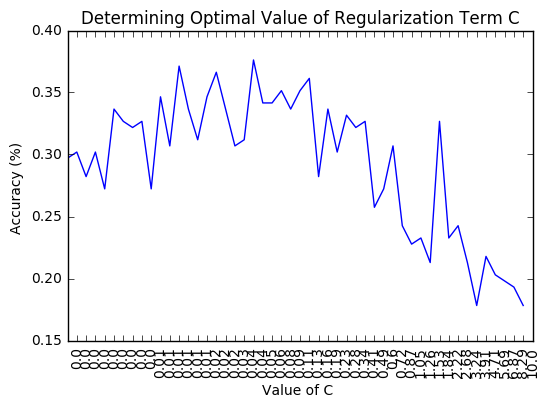

In [34]:
li = [np.arange(1,51)]
plt.plot(cost_accuracies)
plt.title("Determining Optimal Value of Regularization Term C")
plt.xlabel('Value of C ')
plt.ylabel('Accuracy (%) ')
costs_plot = np.around(costs,decimals=2)
plt.xticks(li[0],costs_plot, rotation=90)
plt.figure()

## Comparing our Best Logistic Regression Optimization Procedure to that of Scikit-Learn

In [35]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants


lr_sk = SKLogisticRegression(solver='lbfgs')#,max_iter=100,C=0.005) 

lr_sk_accuracies = []
lr_sk_times = []
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
#     print(X_train)
#     print(y_train)
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    st = time.time()
    lr_sk.fit(X_train,y_train)
    t = (time.time() -st)
    lr_sk_times.append(t)
    #print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
    yhat = lr_sk.predict(X_test)
 
    print("Iterations ",lr_sk.n_iter_)
    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    lr_sk_accuracies.append(acc)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

print(lr_sk_times)
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

Iterations  [100 100 100 100 100]
====Iteration 0  ====
accuracy 0.331683168317
confusion matrix
 [[ 0  0 32  0  0]
 [ 0  0 51  0  0]
 [ 0  0 67  0  0]
 [ 0  0 31  0  0]
 [ 0  0 21  0  0]]
[0.13106894493103027]


20.663905143737793


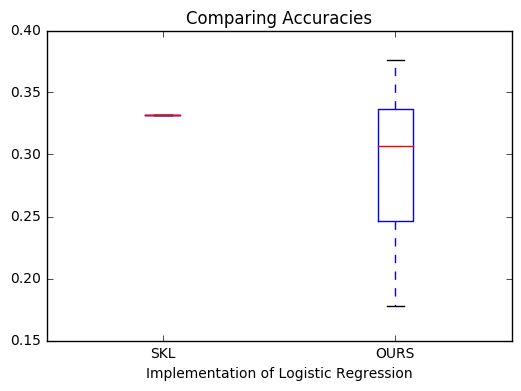

In [36]:
plt.boxplot([lr_sk_accuracies,lr_clf_accuracies])
plt.title("Comparing Accuracies")
plt.xlabel('Implementation of Logistic Regression')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()
print((time.time() -st)*100)
# ax = fig.add_subplot(111)


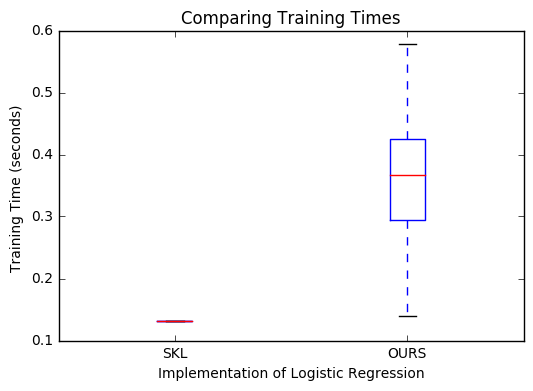

In [37]:
plt.boxplot([lr_sk_times,lr_clf_times])
plt.title("Comparing Training Times")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Training Time (seconds) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

## Analyzing which implementation of Logistic Regression would be best for our case

## Exceptional Work